# Machine Learning Preprocessing Pipeline

The `MLPreprocessor` class provides a scikit-learn-style transformer API for preprocessing gravitational-wave data for machine learning applications. It implements the preprocessing pipeline used in DeepClean v2, including:

- **Data splitting**: Time-ordered train/validation split with integer-second alignment
- **Bandpass filtering**: Butterworth filter with multiple frequency bands
- **Standardization**: Channel-wise normalization (Z-score or robust MAD-based)

This preprocessing is applicable to any machine learning model (DeepClean, Random Forest, XGBoost, etc.), not just deep learning.

In [1]:
# Suppress warnings for cleaner documentation output
import warnings
warnings.filterwarnings('ignore', 'Wswiglal-redir-stdio')
warnings.filterwarnings('ignore', category=UserWarning, module='gwpy.time')

In [2]:
import sys
import os
from pathlib import Path

# Ensure the root directory is in sys.path
root = Path.cwd()
while root.parent != root:
    if (root / "gwexpy").exists():
        if str(root) not in sys.path:
            sys.path.insert(0, str(root))
        break
    root = root.parent

import matplotlib.pyplot as plt
import numpy as np

from gwexpy.signal.preprocessing import MLPreprocessor
from gwexpy.timeseries import TimeSeries, TimeSeriesMatrix

AttributeError: module 'gwpy.io.registry' has no attribute 'register_reader'

## Basic Usage

Let's create some dummy data representing auxiliary (witness) channels and a target strain channel.

In [3]:
# Generate dummy data
np.random.seed(42)
sample_rate = 4096  # Hz
duration = 10  # seconds
n_samples = sample_rate * duration
n_channels = 3

# Witness channels (auxiliary sensors)
witnesses = TimeSeriesMatrix(
    np.random.randn(n_channels, n_samples) * 10 + 50,  # Different mean/std
    t0=0,
    dt=1 / sample_rate,
    unit="m/s^2",
    channel_names=["SEIS-X", "SEIS-Y", "SEIS-Z"],
)

# Target strain channel with 60Hz noise
t = np.arange(n_samples) / sample_rate
signal_60hz = 2 * np.sin(2 * np.pi * 60 * t)
strain = TimeSeries(
    signal_60hz + np.random.randn(n_samples) * 0.5,
    t0=0,
    dt=1 / sample_rate,
    unit="strain",
    name="H1:GDS-CALIB_STRAIN",
)

print(f"Witnesses shape: {witnesses.shape}")
print(f"Strain length: {len(strain)}")
print(f"Duration: {duration} seconds")

NameError: name 'TimeSeriesMatrix' is not defined

### Preprocessing Pipeline

The typical workflow is:
1. **split()**: Divide data into train/validation sets
2. **fit()**: Learn statistics and filter coefficients from training data
3. **transform()**: Apply preprocessing to train/validation data

In [4]:
# Create preprocessor with 55-65 Hz bandpass filter
preprocessor = MLPreprocessor(
    sample_rate=sample_rate,
    freq_low=[55.0],
    freq_high=[65.0],
    valid_frac=0.2,  # 20% validation
    standardization_method="zscore",
)

# Split data
X_train, y_train, X_valid, y_valid = preprocessor.split(witnesses, strain)

print(f"Training samples: {len(y_train)} ({len(y_train)/sample_rate:.1f}s)")
print(f"Validation samples: {len(y_valid)} ({len(y_valid)/sample_rate:.1f}s)")

NameError: name 'MLPreprocessor' is not defined

In [5]:
# Fit on training data
preprocessor.fit(X_train, y_train)

# Transform both train and validation
X_train_proc, y_train_proc = preprocessor.transform(X_train, y_train)
X_valid_proc, y_valid_proc = preprocessor.transform(X_valid, y_valid)

print(f"Processed train X shape: {X_train_proc.shape}")
print(f"Processed train y length: {len(y_train_proc)}")
print(f"Output units: X={X_train_proc.units[0,0]}, y={y_train_proc.unit}")

NameError: name 'preprocessor' is not defined

## Data Splitting Visualization

The split is time-ordered (first portion for training, last for validation) with integer-second alignment to match DeepClean v2 behavior.

NameError: name 'strain' is not defined

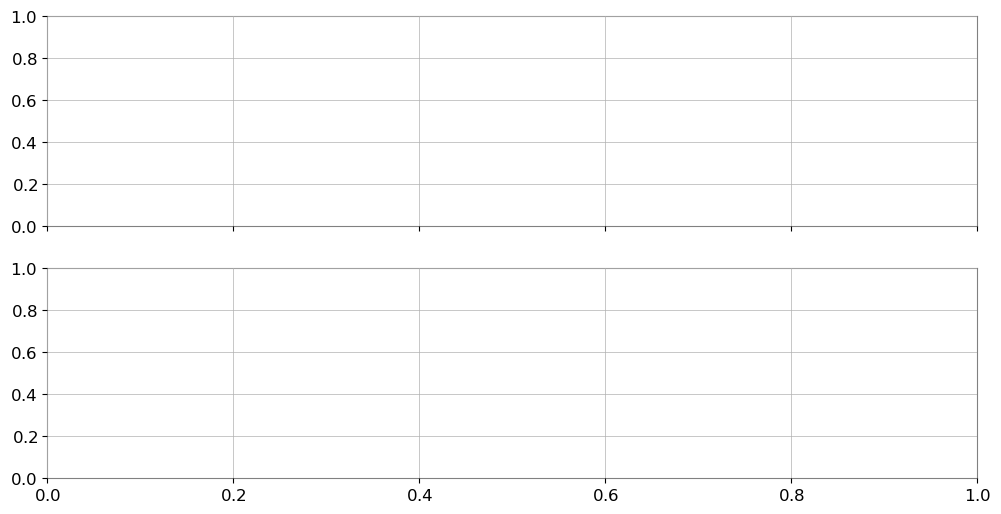

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot original strain
axes[0].plot(strain.times.value, strain.value, alpha=0.7, label="Original")
axes[0].axvline(
    y_train.t0.value + len(y_train) * y_train.dt.value,
    color="r",
    linestyle="--",
    label="Train/Valid split",
)
axes[0].set_ylabel("Strain")
axes[0].legend()
axes[0].set_title("Data Splitting (Time-Ordered)")

# Plot split data
axes[1].plot(
    y_train.times.value, y_train.value, label="Training data", alpha=0.7, color="C0"
)
axes[1].plot(
    y_valid.times.value, y_valid.value, label="Validation data", alpha=0.7, color="C1"
)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Strain")
axes[1].legend()

plt.tight_layout()
plt.show()

## Filtering and Standardization Effects

**Important**: 
- **Witness channels (X)** are NOT filtered, only standardized
- **Target channel (y)** is filtered THEN standardized

This follows DeepClean v2's processing order.

NameError: name 'X_train' is not defined

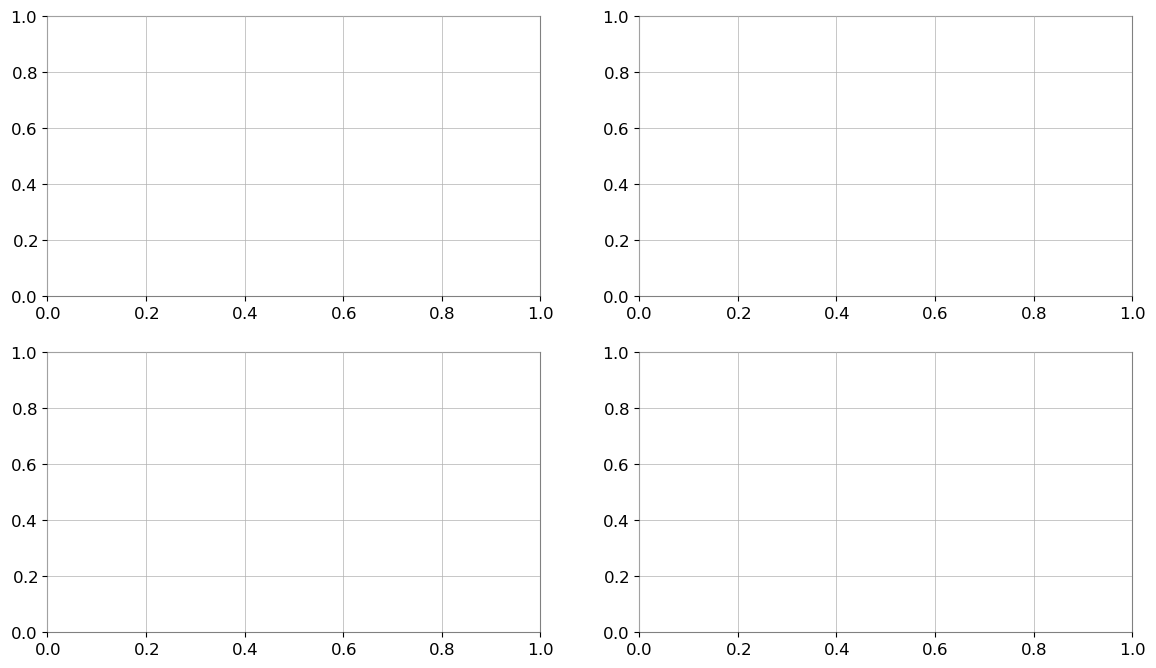

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original witness channel (first 2 seconds)
time_mask = X_train.times.value < 2
axes[0, 0].plot(X_train.times.value[time_mask], X_train.value[0, 0, time_mask])
axes[0, 0].set_title("Witness (Original)")
axes[0, 0].set_ylabel(f"Amplitude ({X_train.units[0,0]})")
axes[0, 0].set_xlabel("Time (s)")

# Standardized witness (NO filtering)
axes[0, 1].plot(X_train_proc.times.value[time_mask], X_train_proc.value[0, 0, time_mask])
axes[0, 1].set_title("Witness (Standardized, No Filter)")
axes[0, 1].set_ylabel("Normalized amplitude")
axes[0, 1].set_xlabel("Time (s)")

# Original target
axes[1, 0].plot(y_train.times.value[time_mask[:len(y_train)]], y_train.value[time_mask[:len(y_train)]])
axes[1, 0].set_title("Target (Original)")
axes[1, 0].set_ylabel(f"Amplitude ({y_train.unit})")
axes[1, 0].set_xlabel("Time (s)")

# Filtered + standardized target
axes[1, 1].plot(y_train_proc.times.value[time_mask[:len(y_train_proc)]], y_train_proc.value[time_mask[:len(y_train_proc)]])
axes[1, 1].set_title("Target (55-65 Hz Filtered + Standardized)")
axes[1, 1].set_ylabel("Normalized amplitude")
axes[1, 1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

### Frequency Domain Analysis

In [8]:
# Compute PSDs
fft_length = 4  # seconds
psd_original = y_train.psd(fftlength=fft_length)
psd_filtered = y_train_proc.psd(fftlength=fft_length)

plt.figure(figsize=(10, 5))
plt.loglog(psd_original.frequencies.value, psd_original.value, label="Original", alpha=0.7)
plt.loglog(psd_filtered.frequencies.value, psd_filtered.value, label="Filtered (55-65 Hz)", alpha=0.7)
plt.axvspan(55, 65, alpha=0.2, color="green", label="Filter band")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Effect of Bandpass Filtering")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.xlim(10, 2000)
plt.show()

NameError: name 'y_train' is not defined

## PyTorch Integration

The preprocessed data can be used with `TimeSeriesWindowDataset` for deep learning models.

In [9]:
try:    from gwexpy.interop import TimeSeriesWindowDataset    import torch    # Create dataset with 8-second windows, 0.0625-second stride    train_dataset = TimeSeriesWindowDataset(        X_train_proc,        labels=y_train_proc,        window=8 * sample_rate,        stride=int(0.0625 * sample_rate),    )    print(f"Dataset size: {len(train_dataset)} windows")    # Get a batch    x_batch, y_batch = train_dataset[0]    print(f"Batch shapes: X={x_batch.shape}, y={y_batch.shape}")    print(f"X dtype: {x_batch.dtype}")    print(f"y dtype: {y_batch.dtype}")    # Create DataLoader    from torch.utils.data import DataLoader    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)    print(f"\nDataLoader created with {len(train_loader)} batches")except ImportError as e:    from IPython.display import Markdown, display    display(Markdown("""**注意**: PyTorchがインストールされていません。この機械学習統合の例を試すには：```bashpip install torch```ノートブックの残りの部分は継続できます。"""))

SyntaxError: invalid syntax (3365732632.py, line 1)

## Advanced Topics

### Multiple Frequency Bands

You can filter multiple frequency bands simultaneously (results are summed).

In [10]:
# Add 120 Hz noise to original data
signal_120hz = 1.5 * np.sin(2 * np.pi * 120 * t)
strain_multi = TimeSeries(
    signal_60hz + signal_120hz + np.random.randn(n_samples) * 0.5,
    t0=0,
    dt=1 / sample_rate,
    unit="strain",
)

# Preprocessor with two bands
preprocessor_multi = MLPreprocessor(
    sample_rate=sample_rate,
    freq_low=[55.0, 110.0],  # Two bands
    freq_high=[65.0, 125.0],
    valid_frac=0.2,
)

X_train_m, y_train_m, X_valid_m, y_valid_m = preprocessor_multi.split(
    witnesses, strain_multi
)
preprocessor_multi.fit(X_train_m, y_train_m)
_, y_train_multi_proc = preprocessor_multi.transform(X_train_m, y_train_m)

print(f"Number of filter bands: {len(preprocessor_multi.filter_coeffs_)}")

# Compare PSDs
psd_multi_orig = y_train_m.psd(fftlength=4)
psd_multi_filt = y_train_multi_proc.psd(fftlength=4)

plt.figure(figsize=(10, 5))
plt.loglog(psd_multi_orig.frequencies.value, psd_multi_orig.value, label="Original", alpha=0.7)
plt.loglog(psd_multi_filt.frequencies.value, psd_multi_filt.value, label="Filtered (2 bands)", alpha=0.7)
plt.axvspan(55, 65, alpha=0.2, color="green", label="Band 1")
plt.axvspan(110, 125, alpha=0.2, color="orange", label="Band 2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Multi-Band Filtering")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.xlim(10, 2000)
plt.show()

NameError: name 't' is not defined

### Robust Standardization

For data with outliers, use `robust` (MAD-based) standardization instead of z-score.

In [11]:
# Create data with outliers
np.random.seed(0)
data_with_outliers = np.random.randn(n_channels, n_samples)
data_with_outliers[0, 1000:1010] = 100  # Inject outliers
witnesses_outliers = TimeSeriesMatrix(
    data_with_outliers, t0=0, dt=1 / sample_rate, unit="m/s^2"
)

# Compare z-score vs robust
prep_zscore = MLPreprocessor(sample_rate=sample_rate, standardization_method="zscore")
prep_robust = MLPreprocessor(sample_rate=sample_rate, standardization_method="robust")

prep_zscore.fit(witnesses_outliers, y=None)
prep_robust.fit(witnesses_outliers, y=None)

X_zscore = prep_zscore.transform(witnesses_outliers, y=None)
X_robust = prep_robust.transform(witnesses_outliers, y=None)

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

time_window = slice(0, 2 * sample_rate)  # First 2 seconds
times = witnesses_outliers.times.value[time_window]

axes[0].plot(times, witnesses_outliers.value[0, 0, time_window])
axes[0].set_title("Original (with outliers at t~0.24s)")
axes[0].set_ylabel("Amplitude")

axes[1].plot(times, X_zscore.value[0, 0, time_window])
axes[1].set_title("Z-score standardization (sensitive to outliers)")
axes[1].set_ylabel("Normalized")

axes[2].plot(times, X_robust.value[0, 0, time_window])
axes[2].set_title("Robust (MAD) standardization (resistant to outliers)")
axes[2].set_ylabel("Normalized")
axes[2].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

print(f"Z-score: mean={np.mean(X_zscore.value[0]):.3f}, std={np.std(X_zscore.value[0]):.3f}")
print(f"Robust:  median={np.median(X_robust.value[0]):.3f}, MAD*1.4826={np.median(np.abs(X_robust.value[0] - np.median(X_robust.value[0]))) * 1.4826:.3f}")

NameError: name 'TimeSeriesMatrix' is not defined

## Summary

The `MLPreprocessor` provides:

1. **Flexible preprocessing** for any ML model (not just DeepClean)
2. **DeepClean v2 compatibility** with identical processing order
3. **Easy integration** with PyTorch, scikit-learn, XGBoost, etc.
4. **Robust handling** of edge cases (single channel, outliers, zero variance)

**Key processing order**:
- Witness channels (X): Standardization only (no filtering)
- Target channel (y): Filtering → Standardization

For more details, see the [API documentation](../../reference/api/preprocessing.rst).